# Customer Churn Prediction with XGBoost
_**이동통신 고객 이탈감지를 위해 Gradient Boosted Trees 사용하기**_

소스 : https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_본 노트북의 내용은 다음 블로그에서도 확인할 수 있습니다. [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

어떤 비즈니스이건 고객을 잃는 것은 손해로 연결됩니다. 불만족스러운 고객을 조기에 감지할 수 있다면 여러분은 그들에게 인센티브를 제공함으로써 보다 더 오래 머물도록 할 기회를 줄 것입니다. 본 노트북은 고객 이탈 예측(Churn Prediction)으로 잘 알려진, 불만족스러운 고객을 사전에 식별하는 유즈케이스를 머신러닝을 이용하여 자동으로 해결하고자 합니다. 머신러닝 모델은 완벽하게 예측하지는 못할 것입니다. 본 노트북은 이런 경우 어떻게 예측이 빗나간 케이스에 대하여 관련된 비용을 수용하는지까지 다룰 것입니다.

고객 이탈 예측 예제에서 우리에게 익숙한 이동통신사 예를 사용할 것입니다. 서비스제공자는 고객이 탈퇴할 생각임을 알게 되면 적절한 타이밍에 인센티브를 제공할 수 있습니다. 전화기를 업그레이드하거나 새로운 기능을 활성화하여 계속 서비스를 사용하도록 합니다. 인센티브는 고객을 잃고 다시 확보하는 것보다 훨씬 비용 효율적인 경우가 많습니다. 


---

## Setup

_본 노트북은 ml.m4.xlarge Sagemaker 노트북에서 생성하고 테스트되었습니다._

다음 설정을 시작합니다.
- 학습과 모델 데이터 저장에 사용할 S3 버켓과 prefix를 선언합니다. SageMaker 노트북 인스턴스와 동일한 리전에 위치해야 합니다.
- 학습과 호스팅 작업에서 데이터에 엑서스할 때 사용할 IAM 역할(role)을 결정합니다. 역할의 생성은 aws 개발자문서를 참고하십시오. 만약 노트북인스턴스, 학습, 호스팅을 위해 하나 여러개의 별도 역할이 필요하다면 boto 정규식으로 표현된 IAM 풀네임 스트링을 사용합니다. 


In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-xgboost-churn"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

필요한 파이썬 라이브러리를 import 합니다. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

---
## Data

이동 통신사에는 어떤 고객이 이탈하고 어떤 고객이 서비스를 계속 사용했는지에 대한 기록이 있습니다. 이 기록 정보를 이용하여 한 이동 통신사의 이탈에 대한 ML 모델을 구성하기 위해 모델을 학습할  할 수 있습니다. 모델을 학습 한 후 다른 임의 고객의 프로필 정보 (모델 학습에 사용한 것과 동일한 프로필 정보)를 모델에 전달하고 모델이이 고객이 이탈할지 여부를 예측하도록 할 수 있습니다. 물론 우리는 모델이 실수를 할 것으로 예상합니다. 결국 미래를 예측하는 것은 어려운 일입니다! 하지만 예측 오류를 처리하는 방법도 보여 드리겠습니다.

우리가 사용하는 데이터 세트는 Daniel T. Larose의 책 [Discovering Knowledge in Data] (https://www.amazon.com/dp/0470908742/) 과 University of California Irvine Repository of Machine Learning Datasets에 언급되고 공개되었습니다. 이제 해당 데이터 세트를 다운로드하고 읽어 보겠습니다.

In [3]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


In [4]:
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


In [5]:
len(churn.columns)

21

In [6]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5000 non-null   object 
 1   Account Length  5000 non-null   int64  
 2   Area Code       5000 non-null   int64  
 3   Phone           5000 non-null   object 
 4   Int'l Plan      5000 non-null   object 
 5   VMail Plan      5000 non-null   object 
 6   VMail Message   5000 non-null   int64  
 7   Day Mins        5000 non-null   float64
 8   Day Calls       5000 non-null   int64  
 9   Day Charge      5000 non-null   float64
 10  Eve Mins        5000 non-null   float64
 11  Eve Calls       5000 non-null   int64  
 12  Eve Charge      5000 non-null   float64
 13  Night Mins      5000 non-null   float64
 14  Night Calls     5000 non-null   int64  
 15  Night Charge    5000 non-null   float64
 16  Intl Mins       5000 non-null   float64
 17  Intl Calls      5000 non-null   i

약 5,000개의 레코드를 가지는 (현재 기준으로는) 매우 작은 데이터셋입니다. 각 레코드는 미국의 어떤 이동통신사 고객의 프로파일을 설명하는 21개의 속성으로 이루어져 있습니다.
속성은 다음과 같습니다:

- `State`: 고객이 거주하는 미국의 주(state), 두자리 문자로 구성됨. (예: OH, NJ)
- `Account Length`: 해당 어카운트가 활성화된 후 경과한 시간 (dyas) 
- `Area Code`: 고객 전화번호에서 3자리 지역 코드 
- `Phone`: 고객 전화번호 중 나머지 7자리 
- `Int’l Plan`: 고객이 국제전화 플랜을 사용하는지 여부 (yes/no)
- `VMail Plan`: 고객이 음성메일 플랜을 사용하는지 여부 (yes/no)
- `VMail Message`: 매달 평균 음성메일 메시지 건수 
- `Day Mins`: 주간(daytime)동안 총 통화시간 
- `Day Calls`: 주간(daytime)동안 총 통화회수
- `Day Charge`: 주간(daytime) 통화에 청구한 비용 
- `Eve Mins, Eve Calls, Eve Charge`: 저녁시간 청구된 비용과 콜 건수, 시간  
- `Night Mins`, `Night Calls`, `Night Charge`: 야간시간 청구된 비용과 콜 건수, 시간
- `Intl Mins`, `Intl Calls`, `Intl Charge`: 국제전화 통화 청구금액 
- `CustServ Calls`: 고객서비스에 전화를 건 회수 
- `Churn?`: 고객이 서비스를 이탈하였는지 여부 (true/false)

마지막 속성인 `Churn?`이 우리가 만들 모델이 예측하고자 하는 목표변수이다. 목표변수가 두개의 값을 가지므로 우리의 모델은 이진분류문제를 해결하는 모델이 될 것입니다. 

다음은 데이터로부터 EDA를 진행해보겠습니다. 데이터타입이 `object`인 컬럼

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


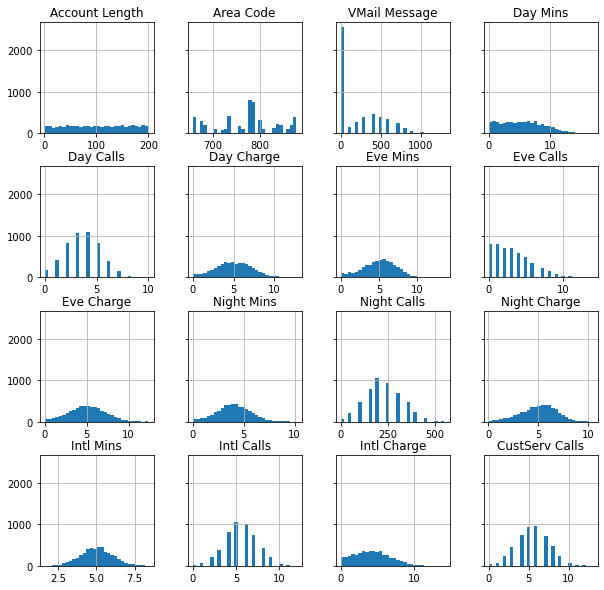

In [7]:
# Frequency tables for each categorical feature
# for column in churn.select_dtypes(include=["object"]).columns:
#     display(pd.crosstab(index=churn[column], columns="% observations", normalize="columns"))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

방금 분석을 통해 바로 다음을 알 수 있다. 

- 고객의 `주(state)`는 고르게 분포되어 있다.
- `Phone` 속성은 너무 많은 고유값을 가지고 있어서 실용적이지 않다. 자리수 중 일부가 특정 의미를 내포할 가능성은 있지만, 이들 번호가 어떻게 할당되는지 알지 못하는 상황으므로 해당 값은 사용하지 않는 것이 좋을것 같다.
- 숫자 속성들 중 대부분은 분포가 고르고 벨모양의 가우시안 분포를 따른다. `음성메일 메시지(VMail Message)` 속성의 분포는 일정하지 않다. 
- `지역코드(Area Code)` 속성은 숫자가 아닌 명목형 변수로 바뀌어야 할 것 같다.


In [8]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

다음은 데이터셋의 각 특성컬럼값들과 목표변수의 관계를 살펴봅니다. 

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


Account Length


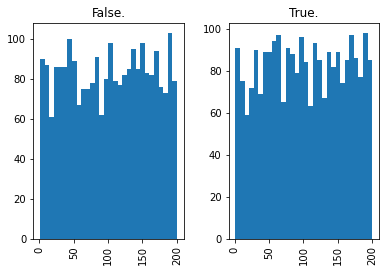

VMail Message


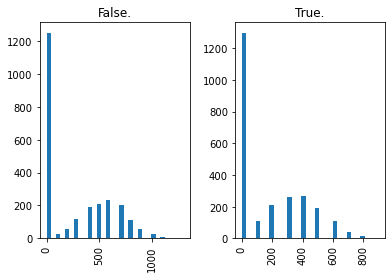

Day Mins


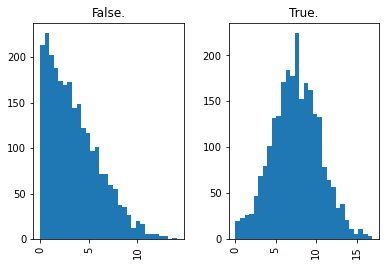

Day Calls


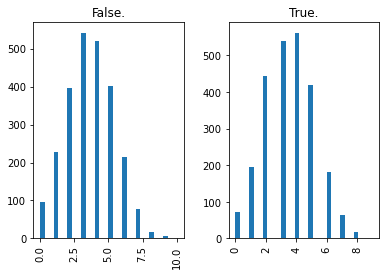

Day Charge


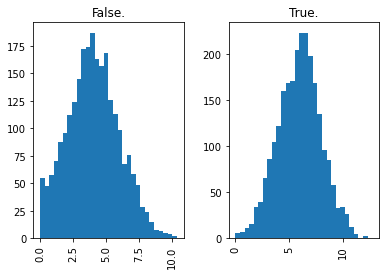

Eve Mins


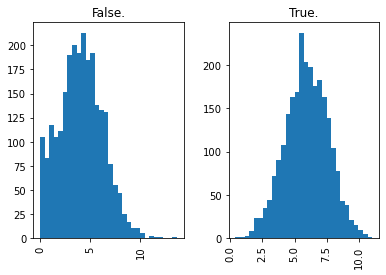

Eve Calls


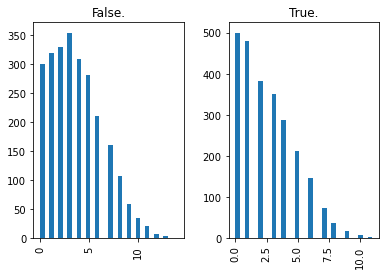

Eve Charge


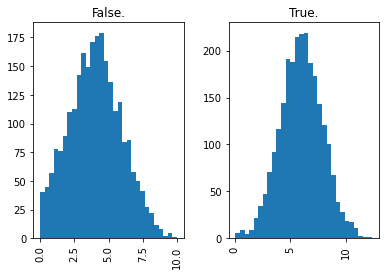

Night Mins


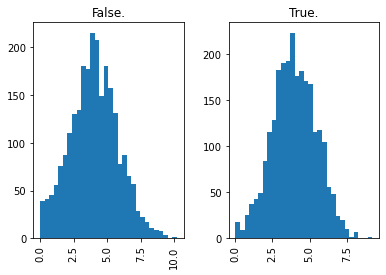

Night Calls


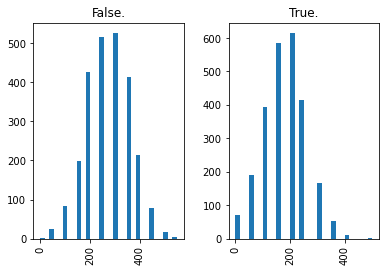

Night Charge


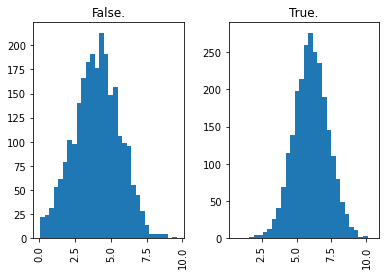

Intl Mins


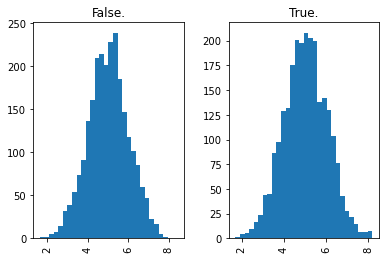

Intl Calls


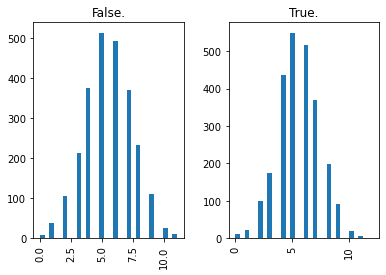

Intl Charge


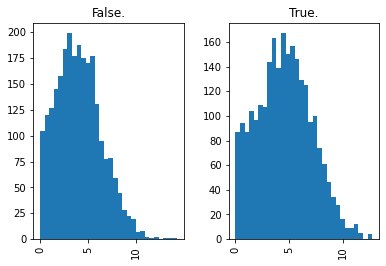

CustServ Calls


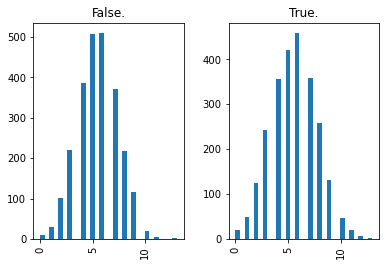

In [9]:
for column in churn.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        display(pd.crosstab(index=churn[column], columns=churn["Churn?"], normalize="columns"))

for column in churn.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = churn[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.009030,-0.015878,0.011659,-0.007468,0.000213,0.026515,-0.012795,0.016400,-0.002383,-0.034925,0.017277,-0.003735,0.028285,-0.036721
VMail Message,-0.009030,1.000000,-0.143272,0.002762,-0.182712,-0.104667,-0.101240,-0.029212,0.061370,0.135042,-0.155475,-0.015162,0.131964,0.010120,0.068657
Day Mins,-0.015878,-0.143272,1.000000,-0.087598,0.667941,0.482641,-0.184939,0.766489,0.188190,-0.445212,0.570508,0.001988,0.236131,0.239331,-0.195322
Day Calls,0.011659,0.002762,-0.087598,1.000000,-0.222556,0.033903,0.185881,-0.052051,-0.085222,-0.083050,0.046641,-0.022548,-0.045671,-0.120064,-0.065518
Day Charge,-0.007468,-0.182712,0.667941,-0.222556,1.000000,0.574697,0.236626,0.371580,0.150700,-0.130722,0.374861,0.010294,0.119584,0.251748,-0.260945
Eve Mins,0.000213,-0.104667,0.482641,0.033903,0.574697,1.000000,-0.067123,0.269980,-0.090515,0.067315,0.317481,-0.015678,0.070456,0.448910,-0.167347
Eve Calls,0.026515,-0.101240,-0.184939,0.185881,0.236626,-0.067123,1.000000,-0.467814,0.221439,0.218149,-0.324936,-0.001593,-0.112062,0.017036,-0.433467
Eve Charge,-0.012795,-0.029212,0.766489,-0.052051,0.371580,0.269980,-0.467814,1.000000,0.184230,-0.454649,0.546137,-0.003569,0.164104,0.243936,-0.011019
Night Mins,0.016400,0.061370,0.188190,-0.085222,0.150700,-0.090515,0.221439,0.184230,1.000000,-0.223023,-0.140482,-0.012781,0.038831,0.271179,-0.332802
Night Calls,-0.002383,0.135042,-0.445212,-0.083050,-0.130722,0.067315,0.218149,-0.454649,-0.223023,1.000000,-0.390333,-0.009821,0.181237,-0.155736,0.110211


<AxesSubplot:>

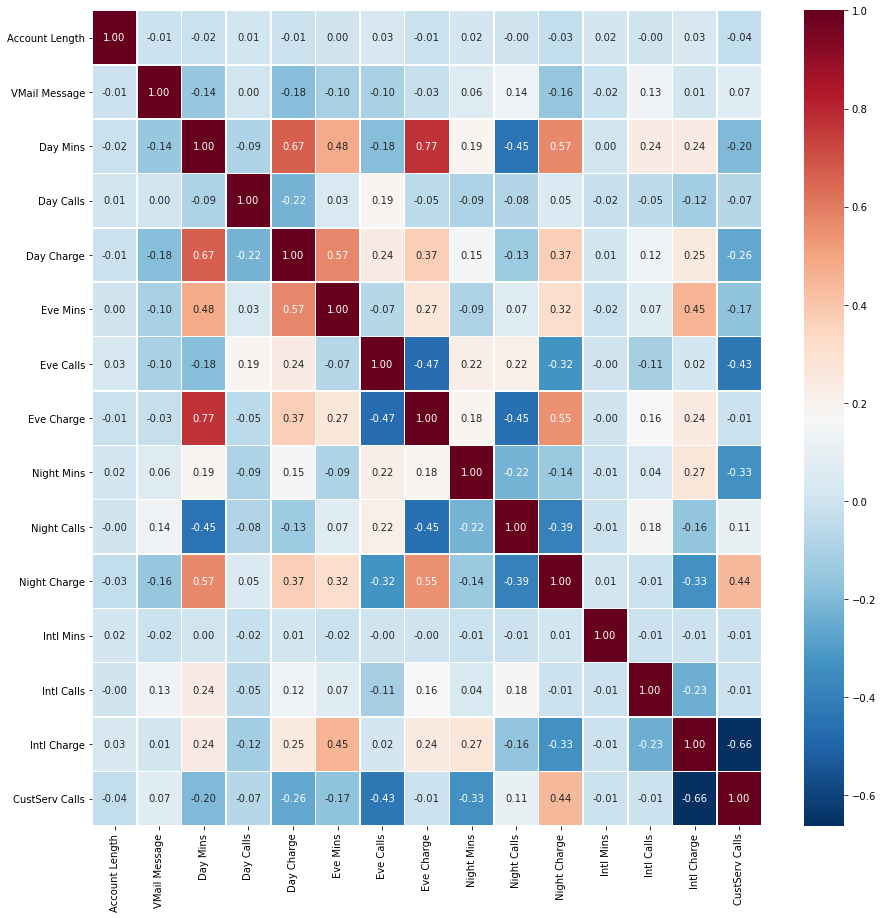

In [10]:
display(churn.corr())
plt.figure(figsize=(15,15))
sns.heatmap(data = churn.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='RdBu_r')

몇몇 속성들은 100%에 가까운 상관관계(correlation) 를 가지고 있습니다. 알고리즘에 따라 어떤 머신러닝 알고리즘에서는 이런 특성을 사용시 악영향을 끼칠 수 있으므로 이를 제외하는 것을 검토할 수 있습니다. 본 에제에서는 높은 상관관계를 보이는 컬럼 중 "Day Charge", "Eve Charge", "Night Charge", "Intl Charge" 컬럼을 제외하도록 하겠습니다.

In [11]:
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

In [12]:
churn.to_csv("revised_churn.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "full/revised_churn.csv")
).upload_file("revised_churn.csv")

이제 데이터 세트를 정리 했으므로 사용할 알고리즘을 결정하겠습니다. 위에서 살펴보았듯 특정 변수의 값이 (중간이 아닌) 높은 값과 낮은 값일 경우 이탈을 예측하는 변수가 있는 것 같습니다. 선형 회귀와 같은 알고리즘에서 이를 수용하려면 다항식 (또는 버케팅된) 항을 생성해야합니다. 대신 여기서는 그래디언트 부스트 트리를 사용하여이 문제를 모델링 해 보겠습니다. Amazon SageMaker는 분산 학습을 하거나 실시간 예측 엔드 포인트로 호스팅하는 등의 기능을 관리형으로 사용할 수있는 XGBoost 컨테이너를 제공합니다. XGBoost는 기능과 대상 변수 간의 비선형 관계를 자연스럽게 설명하고 기능 간의 복잡한 상호 작용을 수용하는 그래디언트 부스트 트리를 사용합니다.

Amazon SageMaker XGBoost는 학습을 위해 CSV 또는 LibSVM 포맷의 데이터를 사용합니다. 본 예제는 CSV를 사용하겠습니다. 데이터셋은 다음 규약을 지켜야 합니다.
- 예측변수를 첫번째 컬럼으로 사용합니다.
- 헤더를 제외합니다. 

CSV로 변환하기 전에 카테고리 변수들을 숫자형으로 변환하였습니다.


In [13]:
model_data = pd.get_dummies(churn)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1
)

데이터를 학습, 검증, 테스트셋으로 나눕니다. 이는 모델이 과적합(overfitting)되는 것을 방지해 주고 학습단계에서 사용되지 않았단 데이터로 모델의 정확도를 테스트할 수 있도록 해 줄 것입니다.

In [14]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

In [15]:
len(train_data.columns)

100

생성한 파일을 S3로 업로드합니다.

In [16]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

---
## Train

학습작업을 위해 XGBoost 알고리즘 컨테이너의 정보를 가져옵니다. (AWS에서 관리형으로 제공되는 알고리즘 컨테이너의 위치를 가져옵니다.)

In [17]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")
display(container)

'433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest'

알고리즘에서 사용할 `TrainingInput` 오브젝트를 생성하면서 조금전 s3로 업로드한 CSV 파일의 정보를 지정합니다. 

In [18]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train/train.csv".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/validation.csv".format(bucket, prefix), content_type="csv"
)

이제 사용하려는 훈련 인스턴스의 유형과 개수와 같은 하이퍼 파라미터와 XGBoost 알고리즘을 위한 하이퍼 파라미터를 지정할 수 있습니다. 몇 가지 주요 하이퍼 파라미터는 다음과 같습니다.

- `max_depth` 알고리즘 내에서 각 트리를 구축 할 수있는 깊이를 제어합니다. 트리가 깊으면 예측이 더 정확할 수 있지만 계산 비용이 더 많이 들고 과적합으로 이어질 수 있습니다. 일반적으로 많은 수의 얕은 트리와 적은 수의 더 깊은 트리 사이에서 탐색해야하는 모델 성능에 약간의 절충이 있습니다. 
- `subsample` 학습데이터의 샘플링을 제어합니다. 이 기법은 과적합을 방지하만 너무 낮은 값을 지정할 경우 모델에 사용되는 데이터가 너무 적어질 수 있습니다. 
- `num_round` 부스팅 회수를 지정합니다. 이 값은 이전 학습의 잔차(residual)을 이용하는 후속 모델의 수를 제어합니다. 마찬가지로 큰 수를 지정하면 학습데이터를 더 잘 할습할 수 있지만 계산 비용이 많이지고 과적합으로 이어질 수 있습니다. 
- `eta` 부스팅을 얼마나 공격적으로 진행할 지를 제어합니다. 큰 값으로 지정시 더 보수적인 부스팅이 발생합니다. 
- `gamma` 얼마나 공격적으로 트리가 성장할지를 제어합니다. 큰 값으로 지정시 보다 보수적인 모델이 생성될 가능성이 높습니다. 

XGBoost의 하이퍼파라미터에 대한 보다 자세한 정보는 다음 Github 페이지를 참조합니다. [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [19]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

2021-12-05 14:10:52 Starting - Starting the training job...
2021-12-05 14:11:15 Starting - Launching requested ML instancesProfilerReport-1638713451: InProgress
......
2021-12-05 14:12:15 Starting - Preparing the instances for training...............
2021-12-05 14:14:38 Downloading - Downloading input data
2021-12-05 14:14:38 Training - Downloading the training image..Arguments: train
[2021-12-05:14:15:00:INFO] Running standalone xgboost training.
[2021-12-05:14:15:00:INFO] File size need to be processed in the node: 1.16mb. Available memory size in the node: 8325.75mb
[2021-12-05:14:15:00:INFO] Determined delimiter of CSV input is ','
[14:15:00] S3DistributionType set as FullyReplicated
[14:15:00] 3500x99 matrix with 346500 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-12-05:14:15:00:INFO] Determined delimiter of CSV input is ','
[14:15:00] S3DistributionType set as FullyReplicated
[14:15:00] 1000x99 matrix with 99000 entries loaded from /opt

---
## Host

이제 XGBoost를 이용한 학습이 끝났습니다. 모델을 생성하고 호스팅 엔드포인트로 배포합니다. 


In [20]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

------!

### Evaluate

이제 호스팅 된 엔드 포인트가 실행 중이므로 http POST 요청을 작성하여 매우 쉽게 모델에서 실시간 예측을 수행 할 수 있습니다. 그러나 먼저`test_data` NumPy 배열을 엔드 포인트에서 실행중인 모델에 전달하기 위해 직렬화(serializer)와 역직렬화(deserializer)를 설정해야합니다.


이제 간단한 함수를 사용하여 다음을 수행합니다.
1. 테스트 데이터 세트를 반복합니다.
1. 행의 미니 배치로 분할
1. 분할한 미니 배치 배열을 페이로드로 하여 XGBoost 엔드포인트 호출 (예측 실행) 
1. 예측결과 리턴

In [21]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return np.fromstring(predictions[1:], sep=",")


predictions = predict(test_data.to_numpy()[:, 1:])

In [22]:
print(predictions)

[1.35331511e-01 9.82077539e-01 1.02474750e-03 4.05021757e-03
 3.92824411e-01 9.72177207e-01 9.91238415e-01 7.27955222e-01
 8.88106227e-01 9.90995705e-01 9.52816725e-01 1.19172679e-02
 3.58281261e-03 9.42603052e-01 9.89126205e-01 9.90786612e-01
 9.89062250e-01 6.96188286e-02 9.03073490e-01 9.86119509e-01
 9.62791502e-01 1.74614764e-03 5.25158504e-03 9.58006740e-01
 9.41856503e-01 1.67768657e-01 9.90760803e-01 2.84090172e-03
 9.95878816e-01 1.79207008e-02 5.64881638e-02 3.02827973e-02
 9.39479709e-01 5.42096049e-03 4.67779767e-03 1.76512660e-03
 5.74744403e-01 4.61890012e-01 9.82370138e-01 9.46011901e-01
 7.24184453e-01 9.79002118e-01 4.35622185e-01 9.47760344e-01
 1.98116549e-03 9.55070615e-01 1.80402584e-03 2.31066555e-01
 9.84024167e-01 2.06405832e-03 4.47656447e-03 9.76536214e-01
 9.76774156e-01 2.38812685e-01 8.62769634e-02 9.92498100e-01
 5.51647916e-02 1.81831885e-03 1.40864691e-02 6.51788637e-02
 3.24071288e-01 9.69274342e-01 8.70716691e-01 2.77617481e-02
 3.38171422e-03 9.865017

기계 학습 모델의 성능을 비교하는 방법은 여러 가지가 있지만 실제 값과 예측 값을 비교하는 것으로 시작하겠습니다. 이 경우 단순히 고객이 이탈했는지 (`1`) 또는 이탈하지 않았는지 (`0`) 예측하여 간단한 혼동 행렬을 생성합니다.


In [23]:
pd.crosstab(
    index=test_data.iloc[:, 0],
    columns=np.round(predictions),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,0.0,1.0
actual,,
0,235,18
1,9,238


_Note, 알고리즘의 랜덤 요소로 인해 결과가 약간 다를 수 있습니다.._

247명 명의 이탈자 중 240 명을 정확하게 예측했습니다 (true positive). 그리고 우리는 15 명의 고객이 이탈 할 것이라고 잘못 예측했습니다. 우리가 이탈이라고 예측하지 않았으나 실제로는 이탈한 7 명의 고객도 있습니다 (false positive).

여기서 중요한 점은 위의 np.round () 함수 때문에 0.5의 간단한 임계 값 (또는 컷오프)을 사용하고 있다는 것입니다. xgboost의 예측은 0과 1 사이의 연속 값으로 나오고 우리는 이 값을 예측을 위한 바이너리 클래스로 변환해야 합니다. 하지만 본 경우에서는 이탈하는 고객이 이탈 할 가능성이있는 고객을 사전에 유지하려고하는 것보다 회사에 더 많은 비용이 들 것으로 예상되므로 이 컷오프를 좀 더 보수적으로 조정하는 것이 좋습니다. 이는 거의 확실하게 false positive를 줄이고 true positive의 값을 늘리도록 변화시킬 것입니다. 

여기서 중요한 점은 위의 np.round () 함수 때문에 0.5의 간단한 임계 값 (또는 컷오프)을 사용하고 있다는 것입니다. xgboost의 예측은 0과 1 사이의 연속 값으로 나오고 시작했던 바이너리 클래스로 강제합니다. 그러나 이탈하는 고객은 이탈 할 가능성이있는 고객을 사전에 유지하려고하는 것보다 회사에 더 많은 비용이들 것으로 예상되므로이 컷오프를 조정하는 것이 좋습니다. 이는 거의 확실하게 위양성 수를 증가시킬 것이지만 참 양성 수를 늘리고 위음성 수를 줄일 수도 있습니다.

컨오프를 위한 대략적인 직관을 얻기 위해 예측의 연속 값을 살펴 보겠습니다.

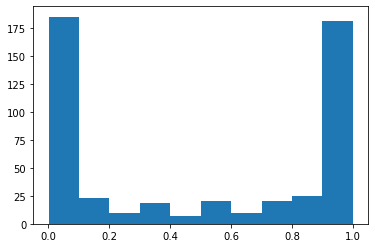

In [24]:
plt.hist(predictions)
plt.show()

모델에서 나오는 예측값이 0 또는 1로 치우치는 경향이 있습니다. 하지만, 0.1에서 0.9 사이에도 충분한 데이터가 있으므로 컷오프를 조정하면 실제로 많은 고객의 예측결과가 바뀔 것입니다. 예를 들면:


In [25]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Churn?_True.,,
0,215,38
1,3,244


컷오프를 0.5에서 0.3으로 변경하면 5 건의 true positive 증가, 14 건의 false postiive 증가, 5 건의 false negative 감소가 발생함을 알 수 있습니다. 전체적으로 숫자는 작지만, 컷오프 변경으로 인한 변화는 전체 고객의 6 ~ 10 %입니다. 컷오프의 조정은 올바른 결정일까요? 우리는 결국 5 명의 추가 고객을 유지하게 될 수 있지만, 이미 이탈하지 않을 14 명의 고객에게 불필요하게 인센티브를 제공했습니다. 최적의 컷오프를 결정하는 것은 실제 환경에서 머신 러닝을 적절하게 적용하기위한 핵심 단계입니다. 이 문제를 더 광범위하게 논의한 다음 현재 문제에 대해 구체적이고 가설적인 솔루션을 적용 해 보겠습니다.


### Relative cost of errors

실제 이진 분류 문제는 이와 유사한 민감한 컷오프를 판단해야 할 가능성이 높습니다. 이는 자체로 문제가 되지는 않습니다. 만약 두 클래스의 점수를 분리하기가 정말 쉽다면 문제는 ML 대신 간단한 규칙으로 해결할 수도 있습니다.

더 중요한 것은, ML모델을 운영환경에 배치하면 모델이 계속해서 생성하는 false postive와 false negative 때문에 비용이 발생한다는 사실입니다. true postive와 true negative 에 의해 발생하는 비용도 따져야합니다. 컷오프의 변경은 이들 네 통계량에 모두 영향을 미치므로 결국 각 예측에 대한 네 가지 결과 각각에 대해 비즈니스에 대한 상대적 비용을 고려해야합니다.


#### Assigning costs

이동 통신사 고객 이탈에 따른 비용은 얼마인가요? 물론 비용은 비즈니스에서 어떤 조치를 취하는 지에 따라 다릅니다. 여기서 몇 가지 가정을 합니다.

먼저 true negative에 \$0의 비용을 할당하십시오. 이 경우 모델은 만족스러운 고객을 정확하게 식별했으며 아무것도 할 필요가 없습니다.

faluse negative 의 경우 이탈하는 고객을 머무를 것으로 잘못 예측하기 때문에 가장 큰 문제가 됩니다. 우리는 고객을 잃게 되고 이전의 수익, 광고 비용, 관리 비용, POS 비용 및 전화 하드웨어 보조금을 포함하여 대체 고객을 확보하는 데 드는 모든 비용을 지불해야 합니다. 빠르게 인터넷을 검색해 본 결과, 이런 비용은 일반적으로 수백 달러에 이르는 것으로 확인되었습니다. 이 예에서는 500달러라고 가정하겠습니다. 

마지막으로, 모델이 이탈할 것으로 예측한 고객에 대해 $ 100의 유지 인센티브를 지불한다고 가정 해 보겠습니다. 고객은 이정도 금액이면 이탈하기 전에 두 번 생각할 것입니다. 이것은 true positive 및 false positive의 비용입니다. false positive (고객이 만족하지만 모델이 이탈하는 것으로 잘못 예측 한 경우)의 경우 100 달러 할인을 "낭비"합니다. 100 달러를 더 효율적으로 사용할 수 있었을 것입니다.하지만 이미 충성도가 높은 고객의 충성도를 높일 수 있으므로 그렇게 나쁘지 않습니다.


#### Finding the optimal cutoff

false negative는 false positive 보다 훨씬 더 많은 비용이 듭니다. 고객 수에 따라 오류를 최적화하는 대신 다음과 같은 비용 함수를 최소화해야합니다.

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

함수로 표현된 FN(C)는 false negative 비율이 컷오프 C에 대한 함수임을 나타냅니다. TN, FP, TP 또한 유사합니다. 
오프 C를 찾아야합니다.

적절한 컷오프값을 찾는 간단한 방법은 많은 가능한 컷오프에 대해 시뮬레이션을 실행하는 것입니다. 아래 for 루프에서 가능한 100 개의 값을 테스트합니다.

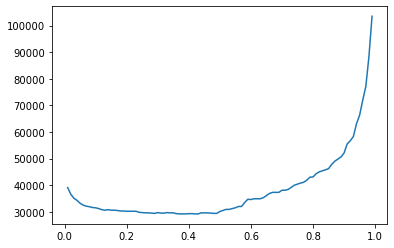

In [26]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(
        np.sum(
            np.sum(
                np.array([[0, 100], [500, 100]])
                * pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > c, 1, 0))
            )
        )
    )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()

In [27]:
print(
    "Cost is minimized near a cutoff of:",
    cutoffs[np.argmin(costs)],
    "for a cost of:",
    np.min(costs),
)

Cost is minimized near a cutoff of: 0.37 for a cost of: 29200


위의 차트는 임계 값을 너무 낮게 선택하면 모든 고객에게 유지 인센티브가 주어짐에 따라 비용이 급증하는 결과를 보여줍니다. 한편 임계 값을 너무 높게 설정하면 고객을 너무 많이 잃게되어 결국 다시 큰 비용이 들게됩니다. 컷오프를 0.37로 설정하면 전체 비용은 \$29,200로 최소화 할 수 있습니다.


---
## Extensions

이 노트북은 고객 이탈 가능성을 예측하는 모델을 구축하는 방법과 true positive, false positive 및 false negative 를 최적으로 설정하는 방법을 보여주었습니다. 이 모델은 다음 내용으로 확장될 수 있습니다. 
- 유지 인센티브를 받는 고객 중 일부는 여전히 이탈합니다. 인센티브 프로그램에서 인센티브를 받았음에도 불구하고 이탈하는 가능성을 포함시키면 더 나은 ROI를 얻을 수 있습니다.
- 저가 요금제로 전환하거나 유료 부가기능을 비활성화 한 고객은 다른 이탈 유형을 나타낸다면 이를 별도의 모델링으로 분리할 수 있습니다. 
- 고객 행동의 변화를 모델링할 수 있습니다. 사용량이 감소하고 고객서비스에 대한 호출 수가 증가하는 경우 이탈하게될 가능성이 높아진다면 고객 프로필에 행동 트랜드를 추가하여 고려할 수 있습니다.
- 실제 비즈니스에서 학습데이터와 비용 할당은 보다 복잡할 것입니다.
- 이탈의 유형별로 여러 모델이 필요할 수 있습니다. 

그리고 이 노트북에서 설명 된 원칙들은 복잡성이 추가되더라도이 유사하게 적용될 수 있습니다.

---
## Store variables
노트북2 실행을 위해 필요한 변수들을 저장한 후 2번 노트북 예제로 이동하여 HPO를 실행합니다.

In [28]:
%store s3_input_train s3_input_validation test_data predictions train_data validation_data

Stored 's3_input_train' (TrainingInput)
Stored 's3_input_validation' (TrainingInput)
Stored 'test_data' (DataFrame)
Stored 'predictions' (ndarray)
Stored 'train_data' (DataFrame)
Stored 'validation_data' (DataFrame)


---
### (Optional) Clean-up

모든 작업을 완료하였다면 추가 요금발생을 막기 위해 아래 셀을 실행하십시오. 아래 코드는 생성한 호스팅 엔드포인트를 제거합니다. 

In [29]:
xgb_predictor.delete_endpoint()